# 1. Activation function

In [1]:
import torch

In [2]:
def sigma(x):
    return torch.tanh(x)
    
def dsigma(x):
    return 1-torch.tanh(x)**2

# 2. Loss

In [44]:
def loss(x,y):
    return torch.norm(x-y)**2

def dloss(x,y):
    return 2*(x-y)


# 3. Forward and backward passes

In [45]:
def forward(w1, b1, w2, b2, x):
    s1=torch.mm(w1, x)+b1
    x1=sigma(s1)
    s2=torch.mm(w2, x1)+b2
    x2=sigma(s2)
    return x, s1, x1, s2, x2
    
def backward_pass(w1, b1, w2, b2, t, x, s1, x1, s2, x2):
    dl_dx2=dloss(x2, t)
    ds2_dx1 = w2.T
    dx1_ds1 = torch.diag(dsigma(s1).squeeze())
    dx2_ds2 = torch.diag(dsigma(s2).squeeze())
    dl_ds2=torch.mm(dx2_ds2, dl_dx2)
    dx2_dx1 = torch.mm(ds2_dx1, dx2_ds2)
    dl_dx1 = torch.mm(dx2_dx1, dl_dx2)
    dl_ds1 = torch.mm(dx1_ds1, dl_dx1)
    ds1_dw1 = x.T
    dl_dw1 = torch.mm(dl_ds1, ds1_dw1)
    ds2_dw2 = x1.T
    dl_dw2 = torch.mm(dl_ds2, ds2_dw2)   
    dl_db1 = dl_ds1
    dl_db2 = dl_ds2
    return dl_dw1, dl_dw2, dl_db1, dl_db2
    
    

In [46]:
# x, s1, x1, s2, x2 = forward(w1, b1, w2, b2, train_input[0].unsqueeze(1))
# t=torch.randn(x2.size())

In [47]:
# backward_pass(w1, b1, w2, b2, t, x, s1, x1, s2, x2, dl_dw1, dl_db1, dl_dw2, dl_db2);

# 4. Data

In [48]:
from  dlc_practical_prologue import load_data
train_input, train_target, test_input, test_target = load_data(one_hot_labels = True, normalize = True)

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


/home/aims/anaconda3/envs/NewEnv1/lib/python3.7/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/aims/anaconda3/envs/NewEnv1/lib/python3.7/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/aims/anaconda3/envs/NewEnv1/lib/python3.7/site-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/aims/anaconda3/envs/NewEnv1/lib/python3.7/site-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [49]:
train_target=train_target*0.9
test_target=test_target*0.9

In [50]:
import matplotlib.pyplot as plt, numpy

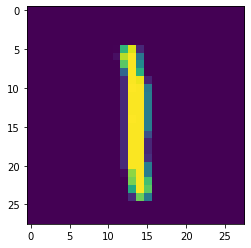

In [51]:
plt.imshow(train_input.unsqueeze(1)[14].view(28,28))

# Training the net

In [52]:
def prediction(x):
    idx=x.argmax(dim=1)
    pred=torch.zeros_like(x)
    pred[torch.arange(x.size(0)), idx]=0.9
    return pred

In [59]:
eps=1e-6
w1=torch.normal(mean=torch.zeros((50, 784)), std=torch.ones((50, 784))*eps)
w2=torch.normal(mean=torch.zeros((10, 50)), std=torch.ones((10, 50))*eps)
b1=torch.normal(mean=torch.zeros((50, 1)), std=torch.ones((50, 1))*eps)
b2=torch.normal(mean=torch.zeros((10, 1)), std=torch.ones((10, 1))*eps)

num_epoch=1000
lr=1e-4

for i in range(num_epoch):
    dl_dw1=torch.zeros_like(w1)
    dl_dw2=torch.zeros_like(w2)
    dl_db1=torch.zeros_like(b1)
    dl_db2=torch.zeros_like(b2)
    X2=[]
    X2_t1=[]
    for idx in range(train_input.size(0)):
        x=train_input[idx].unsqueeze(1)
        t=train_target[idx].unsqueeze(1)
        t1=test_target[idx].unsqueeze(1)
        x_t1=test_input[idx].unsqueeze(1)
        _, s1, x1, s2, x2 = forward(w1, b1, w2, b2, x)
        X2.append(x2.T)
        _, _, _, _, x2_t1=forward(w1, b1, w2, b2, x_t1)
        new_dl_dw1, new_dl_dw2, new_dl_db1, new_dl_db2 = backward_pass(w1, b1, w2, b2, t, x, s1, x1, s2, x2)
        X2_t1.append(x2_t1)
        dl_dw1 += new_dl_dw1
        dl_dw2 += new_dl_dw2
        dl_db1 += new_dl_db1
        dl_db2 += new_dl_db2
        
    X2 = torch.stack(X2, dim=0).squeeze()
    X2_t1 = torch.stack(X2_t1, dim=0).squeeze()
    w1 -= lr*dl_dw1
    w2 -= lr*dl_dw2
    b1 -= lr*dl_db1
    b2 -= lr*dl_db2
    if i%10 == 0:
        accuracy1 = ((prediction(X2) == train_target).all(dim=1)*1.0).mean()
        accuracy2 = ((prediction(X2_t1) == test_target).all(dim=1)*1.0).mean()
        print("Epoch : {}/{}, training loss : {:.3f}, test loss : {:.3f}, accu_train : {:.2f}%, accu_test : {:.2f}%".format(i, num_epoch, \
                                                           loss(x2, t), loss(x2_t1, t1), accuracy1*100, accuracy2*100))

Epoch : 0/1000, training loss : 0.810, test loss : 0.810, accu_train : 9.90%, accu_test : 11.60%
Epoch : 10/1000, training loss : 0.739, test loss : 0.731, accu_train : 11.70%, accu_test : 9.90%
Epoch : 20/1000, training loss : 0.739, test loss : 0.730, accu_train : 11.70%, accu_test : 9.90%
Epoch : 30/1000, training loss : 0.739, test loss : 0.729, accu_train : 26.20%, accu_test : 21.60%
Epoch : 40/1000, training loss : 0.731, test loss : 0.635, accu_train : 32.50%, accu_test : 29.50%
Epoch : 50/1000, training loss : 0.497, test loss : 0.598, accu_train : 53.40%, accu_test : 47.70%
Epoch : 60/1000, training loss : 0.453, test loss : 0.584, accu_train : 60.80%, accu_test : 57.60%
Epoch : 70/1000, training loss : 0.399, test loss : 0.630, accu_train : 73.70%, accu_test : 68.80%
Epoch : 80/1000, training loss : 0.329, test loss : 0.719, accu_train : 78.70%, accu_test : 72.70%
Epoch : 90/1000, training loss : 0.307, test loss : 0.669, accu_train : 81.50%, accu_test : 70.50%
Epoch : 100/10

In [54]:
prediction(X2).argmax(dim=1)

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        8, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        5, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 2, 7,
        1, 6, 3, 0, 2, 1, 1, 7, 0, 0, 2, 6, 7, 8, 3, 9, 0, 4, 6, 7, 4, 6, 8, 0,
        7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2, 9, 3, 1, 1, 0, 4, 9, 2, 0, 0,
        2, 0, 2, 7, 1, 8, 6, 4, 1, 6, 3, 4, 8, 9, 1, 3, 3, 8, 5, 4, 7, 7, 4, 2,
        8, 5, 8, 6, 7, 3, 4, 6, 1, 9, 9, 6, 0, 3, 7, 2, 8, 2, 9, 4, 4, 6, 4, 9,
        7, 0, 9, 2, 9, 5, 1, 5, 9, 1, 2, 3, 2, 3, 5, 9, 1, 7, 6, 2, 8, 2, 2, 5,
        0, 7, 4, 9, 7, 8, 3, 2, 1, 1, 8, 3, 6, 1, 0, 3, 1, 0, 0, 1, 7, 2, 7, 3,
        0, 4, 6, 5, 2, 6, 4, 7, 1, 8, 9, 9, 3, 0, 7, 1, 0, 2, 0, 3, 5, 4, 6, 5,
        8, 6, 3, 7, 5, 8, 0, 9, 1, 0, 3, 1, 2, 2, 3, 3, 6, 4, 7, 5, 0, 6, 2, 7,
        9, 8, 5, 9, 2, 1, 1, 4, 4, 5, 6, 4, 1, 2, 2, 3, 9, 3, 9, 0, 5, 9, 6, 5,
        7, 4, 1, 3, 4, 0, 4, 8, 0, 4, 3,

In [57]:
((train_target.argmax(dim=1)==prediction(X2).argmax(dim=1))*1.0).mean()

tensor(0.9850)

In [58]:
((test_target.argmax(dim=1)==prediction(X2_t1).argmax(dim=1))*1.0).mean()

tensor(0.8500)